In [1]:
elastic_rods_dir = '../../../elastic_rods/python/'
weaving_dir = '../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('new_kitty_1', thickness, width, weaving_dir)
#  [ ear 214, ear 255, nose 39]

0.033273539253433904 0.0023291477477403733


In [4]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 1

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [6]:
set_surface_view_options(curved_linkage_view, surface_transparent = True)

In [7]:
double_view = get_double_side_view(curved_linkage, flip = True)

In [8]:
# double_view.show()

In [9]:
double_view.getCameraParams()

((0.0, 0.0, 5.0), (0.0, 1.0, 0.0), (0.0, 0.0, 0.0))

In [10]:
curved_linkage.setExtendedDoFsPSRL(np.load('../nature_paper_experiments/figure_4/results/new_kitty_1/new_kitty_1_dof.npy'))

In [11]:
curved_linkage.attraction_weight = 0.1

In [12]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [13]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.00144605	1.43674	1.43674	1	1
1	0.000190229	0.104318	0.104318	1	1
2	0.000123666	0.0283481	0.0283481	1	1
3	9.04679e-05	0.0132584	0.0132584	1	1
4	6.73347e-05	0.00652036	0.00652036	1	1
5	5.09509e-05	0.00330448	0.00330448	1	1
6	4.0247e-05	0.00188722	0.00188722	1	1
7	3.42566e-05	0.00138165	0.00138165	1	0
8	3.0268e-05	0.00987731	0.00987731	1	0
9	3.01829e-05	0.000634254	0.000634254	1	0
10	3.01796e-05	4.45464e-05	4.45464e-05	1	0
11	3.01795e-05	1.27044e-06	1.27044e-06	1	0
12	3.01795e-05	6.25209e-10	6.25209e-10	1	0


In [14]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [15]:
optimizer.scaleJointWeights(0.6, 100, [214, 255, 39])

In [16]:
# optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -1, 2)

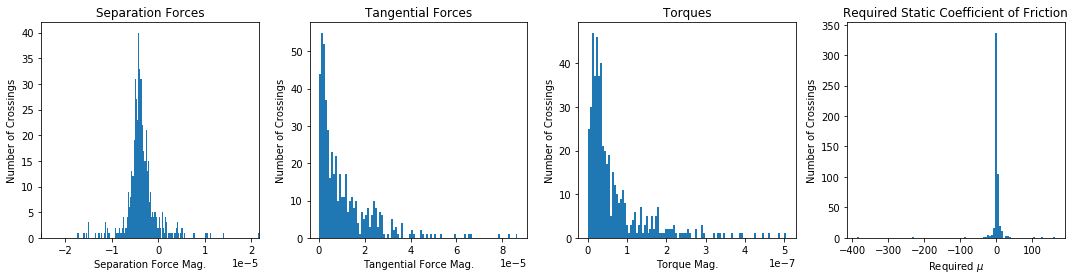

In [17]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [ ]:
optimizer.beta = 1e6
optimizer.scaleJointWeights(0.1, 1000, [396, 412, 497])
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, -1, contact_weight = 1e6, normalWeight = 5, torqueWeight = 2)

In [ ]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()